In [152]:
import os
import sys
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import cm

In [153]:
cwd = pathlib.Path().resolve()
src = cwd.parent
root = src.parent
sys.path.append(str(src))

In [154]:
from models.RNN import SimpleRNN
from utils.simulation import Simulation
from utils.train import train_and_validate, evaluate_model, train
from utils.watertopo import WaterTopo

In [155]:
# loading the data
tra_datapath = str(root)+"/data/normalized_data/tra_val"
test_datapath = str(root)+"/data/normalized_data/test1"
grid_size = 64
sim_amount = 10
test_amount = 5

# select one simulation for training
sims = WaterTopo.load_simulations(save_folder = tra_datapath,
                                  sim_amount = sim_amount,
                                  number_grids = grid_size)

test = WaterTopo.load_simulations(save_folder=test_datapath,
                                  sim_amount = test_amount,
                                  number_grids = grid_size)

### Process all the simulations for training and validation

In [156]:
def dataprocessing(data, sim_amount, timestep, gridsize):
    '''
    # Reshape the data into into the 2D array with
    # each row representing the pixels (each pixel is regarded as a new variable)
    # each column representing the timestep (condider the temporal features as the other dimension of images)
    '''

    wd = np.zeros((sim_amount,timestep,gridsize,gridsize))
    dem = np.zeros((sim_amount,timestep,gridsize,gridsize))
    # create waterlavel as the output
    wl = np.zeros((sim_amount,timestep,gridsize,gridsize))

    for i in range(sim_amount):
        wd[i] =  data[i].wd
        dem[i] = data[i].topography
        wl[i] = wd[i] + dem[i]

    def dataconvert(meshdata,timestep,gridsize):
        tempCNN_array = np.zeros((gridsize*gridsize,timestep))
        for i in range(timestep):
            tempCNN_array[:,i] = meshdata[i].reshape(-1)
        return tempCNN_array

    dem_new = []
    wd_new = []
    wl_new = []

    for i in range(sim_amount):
        dem_new.append(dataconvert(dem[i],timestep,gridsize))
        wd_new.append(dataconvert(wd[i],timestep,gridsize))
        wl_new.append(dataconvert(wl[i],timestep,gridsize))

    return dem_new, wd_new, wl_new

In [157]:
# Training data
dem_new, wd_new, wl_new = dataprocessing(sims, sim_amount = sim_amount, timestep = timestep, gridsize= grid_size)

# Testing data
dem_test, wd_test, wl_test = dataprocessing(test, sim_amount = test_amount, timestep = timestep, gridsize= grid_size)


In [158]:

# timestep = len(sims[0].wd)
# wd = np.zeros((sim_amount,timestep,grid_size,grid_size))
# dem = np.zeros((sim_amount,timestep,grid_size,grid_size))
# # create waterlavel as the output
# wl = np.zeros((sim_amount,timestep,grid_size,grid_size))

# for i in range(sim_amount):
#     wd[i] =  sims[i].wd
#     dem[i] = sims[i].topography
#     wl[i] = wd[i] + dem[i]


# print(dem.shape)
# print(wd.shape)

# def dataconvert(meshdata,timestep,gridsize):
#     tempCNN_array = np.zeros((gridsize*gridsize,timestep))
#     for i in range(timestep):
#         tempCNN_array[:,i] = meshdata[i].reshape(-1)
#     return tempCNN_array

# dem_new = []
# wd_new = []
# wl_new = []

# for i in range(sim_amount):
#     dem_new.append(dataconvert(dem[i],timestep,grid_size))
#     wd_new.append(dataconvert(wd[i],timestep,grid_size))
#     wl_new.append(dataconvert(wl[i],timestep,grid_size))

### Process the testing data

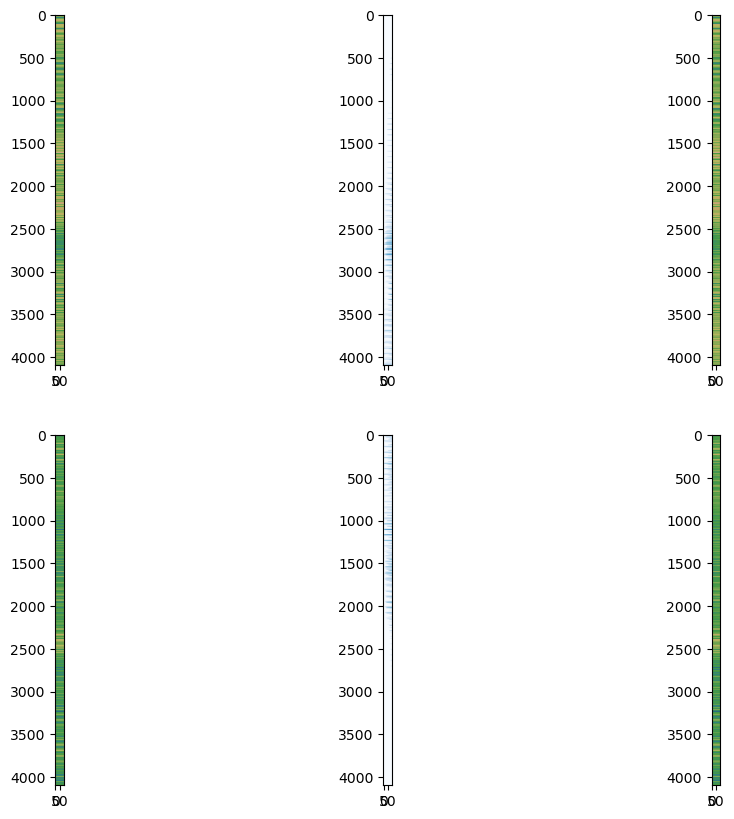

In [159]:
# Define the color
color_dem = cm.gist_earth
color_water = 'Blues'

fig, axs = plt.subplots(2,3 , figsize = (12,10))
axs[0,0].imshow(dem_new[0], cmap = color_dem)
axs[0,1].imshow(wd_new[0], cmap = color_water)
axs[0,2].imshow(wl_new[0], cmap = color_dem)

axs[1,0].imshow(dem_test[0], cmap = color_dem)
axs[1,1].imshow(wd_test[0], cmap = color_water)
axs[1,2].imshow(wl_test[0], cmap = color_dem)

### Split the data

In [160]:
dem_tra, dem_val, wd_tra, wd_val, wl_tra, wl_val, ix_tra, ix_tst = train_test_split(
    dem_new, wd_new, wl_new, np.arange(sim_amount), test_size=0.30, shuffle=True, random_state=42)

### Create the input for the model by combining dem and water depth and the output 

In [161]:
train_inputs = np.stack((dem_tra, wd_tra),1)
train_outputs = np.array(wl_tra)[:,None]

val_inputs = np.stack((dem_val, wd_val),1)
val_outputs = np.array(wl_val)[:,None]

test_inputs = np.stack((dem_test, wd_test),1)
test_outputs = np.array(wl_test)[:,None]

print(train_inputs.shape)
print(train_outputs.shape)

print(test_inputs.shape)
print(test_outputs.shape)

(7, 2, 4096, 97)
(7, 1, 4096, 97)
(5, 2, 4096, 97)
(5, 1, 4096, 97)


In [171]:
train_dataset = TensorDataset(torch.tensor(train_inputs, dtype=torch.float32), torch.tensor(train_outputs, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(val_inputs, dtype=torch.float32), torch.tensor(val_outputs, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_inputs, dtype=torch.float32), torch.tensor(test_outputs, dtype=torch.float32 ))

### Use the Unet Encoder-Decoder CNN to train the model  

In [163]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, bias=False, batch_norm=True):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=bias)]
        if batch_norm:
            layers.append(nn.BatchNorm2d(num_features=out_channels))
        layers.append(nn.PReLU())
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=bias))

        self.cnnblock = nn.Sequential(*layers)

    def forward(self, x):
        return self.cnnblock(x)

class Encoder(nn.Module):
    def __init__(self, channels=[4, 8, 16], kernel_size=3, padding=1, bias=False, batch_norm=True):
        super().__init__()

        self.enc_blocks = nn.ModuleList([
            CNNBlock(channels[block], channels[block+1], kernel_size, padding, bias,
                     batch_norm=batch_norm)
            for block in range(len(channels)-1)]
            )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)

    def forward(self, x):
        outs = []
        for block in self.enc_blocks:
            x = block(x)
            outs.append(x)
            x = self.pool(x)
        return outs

class Decoder(nn.Module):
    def __init__(self, channels=[16, 8, 4], kernel_size=3, padding=1, bias=False, batch_norm=True):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([
            nn.ConvTranspose2d(channels[block], channels[block+1], kernel_size=2, padding=0, stride=1)
            for block in range(len(channels)-1)]
            )
        self.dec_blocks = nn.ModuleList([
            CNNBlock(channels[block], channels[block+1], kernel_size, padding, bias,
                     batch_norm=batch_norm)
             for block in range(len(channels)-1)]
             )

    def forward(self, x, x_skips):
        for i in range(len(x_skips)):
            x = self.upconvs[i](x)
            x = torch.cat((x, x_skips[-(1+i)]), dim=1)
            x = self.dec_blocks[i](x)

        x = self.dec_blocks[-1](x)
        return x

class CNN(nn.Module):
    def __init__(self, node_features, out_dim=1, n_downsamples=3, initial_hid_dim=64, batch_norm=True,
                 bias=True):
        super(CNN, self).__init__()
        hidden_channels = [initial_hid_dim*2**i for i in range(n_downsamples)]
        encoder_channels = [node_features]+hidden_channels
        decoder_channels = list(reversed(hidden_channels))+[out_dim]

        self.encoder = Encoder(encoder_channels, kernel_size=3, padding=1,
                               bias=bias, batch_norm=batch_norm)
        self.decoder = Decoder(decoder_channels, kernel_size=3, padding=1,
                               bias=bias, batch_norm=batch_norm)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x[-1], x[:-1])
        x = nn.Sigmoid()(x)
        return x

In [172]:
node_features = 2 # Water Depth and DEM
model = CNN(node_features=node_features,
            n_downsamples=4,
            initial_hid_dim=4,
            batch_norm=True, bias=True)

In [165]:
# display(model)

### Define the training parameter, the optimizer, and the dataloader

In [173]:
# Set training parameters
learning_rate = 0.001
batch_size = 10
num_epochs = 60
device = 'cpu'
# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
model_name = 'TempCNN'
save_path = "../results/trained_models/" + model_name
# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [174]:
# train_loader.dataset[0]
# val_loader.dataset[0]

(tensor([[[ 0.0034,  0.0034,  0.0034,  ...,  0.0034,  0.0034,  0.0034],
          [ 0.5575,  0.5575,  0.5575,  ...,  0.5575,  0.5575,  0.5575],
          [ 1.0070,  1.0070,  1.0070,  ...,  1.0070,  1.0070,  1.0070],
          ...,
          [-1.4112, -1.4112, -1.4112,  ..., -1.4112, -1.4112, -1.4112],
          [-2.1340, -2.1340, -2.1340,  ..., -2.1340, -2.1340, -2.1340],
          [-2.2769, -2.2769, -2.2769,  ..., -2.2769, -2.2769, -2.2769]],
 
         [[ 0.0038,  0.5644,  0.5662,  ...,  0.5663,  0.5663,  0.5663],
          [ 0.0000,  0.3390,  0.3408,  ...,  0.3409,  0.3409,  0.3409],
          [ 0.0000,  0.1487,  0.1505,  ...,  0.1505,  0.1505,  0.1505],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]]),
 tensor([[[ 0.0072,  0.5679,  0.5697,  ...,  0.5697,  0.5697,  0.5697],
          [ 0.5575,  0.8966,

### Training and Validating 

In [175]:
train_losses, val_losses, best_val_loss, time = train_and_validate(
                                                                   model = model,
                                                                   train_loader = train_loader,
                                                                   val_loader = val_loader,
                                                                   criterion = criterion,
                                                                   optimizer = optimizer,
                                                                   num_epochs = num_epochs,
                                                                   device = device,
                                                                   save_path = save_path
                                                                  )

Epoch 20/60 Train Loss: 0.8674, Validation Loss: 1.0054 Best Validation Loss: 1.0054
Epoch 40/60 Train Loss: 0.8129, Validation Loss: 0.8282 Best Validation Loss: 0.8282
Epoch 60/60 Train Loss: 0.7652, Validation Loss: 0.8054 Best Validation Loss: 0.8054
Training complete.


In [178]:
test_loss = evaluate_model(model, test_loader, criterion, device=device)
print(test_loss)

0.7970787286758423


### Visualisation of results

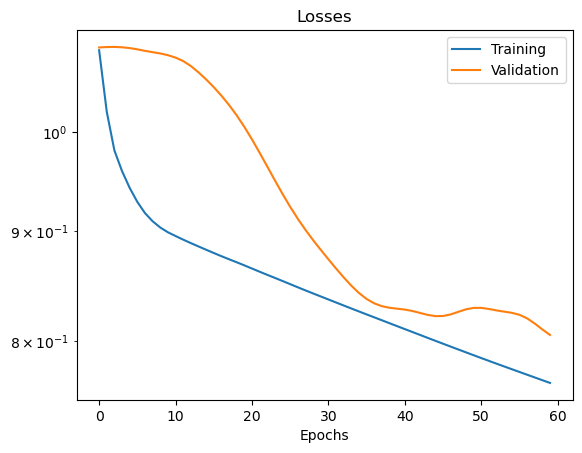

In [179]:
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.yscale('log')
plt.title('Losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [234]:
# select one sample
data_id = 3

x = test_dataset[data_id][0].unsqueeze(0)
WL= test_dataset[data_id][1]

# predict the FAT
pred_WL = model(x).detach()

demx = x.squeeze(0)[0].reshape(grid_size,grid_size,timestep).permute((2,0,1))
WL = WL.squeeze(0).reshape(grid_size,grid_size,timestep).permute((2,0,1))
pred_WL = pred_WL.squeeze(0,1).reshape(grid_size,grid_size,timestep).permute((2,0,1))


In [235]:
print(demx.size())
print(WL.size())
print(pred_WL.size())



torch.Size([1, 2, 4096, 97])
torch.Size([97, 64, 64])
torch.Size([97, 64, 64])


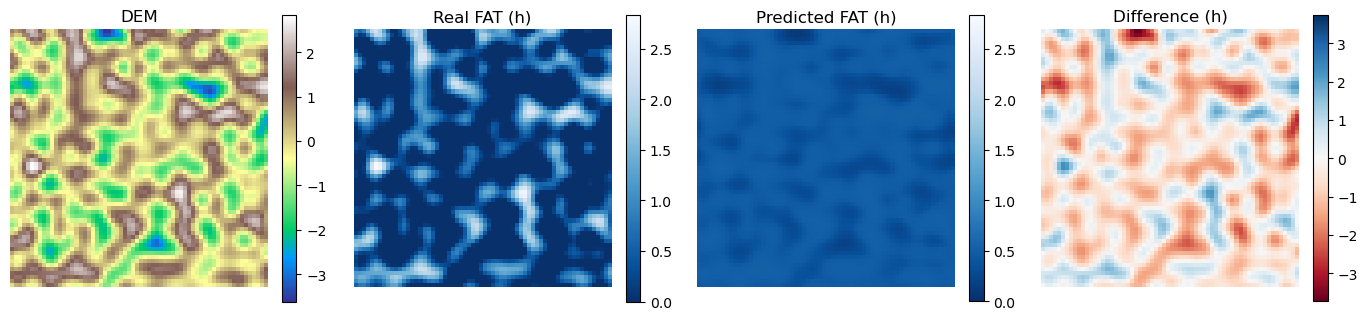

In [237]:
from matplotlib.colors import TwoSlopeNorm

fig, axs = plt.subplots(1, 4, figsize=(17,5))

diff_WL = WL - pred_WL
max_FAT = max(pred_WL.max(), WL.max())
max_diff = max(diff_WL.max(), -diff_WL.min())

axs[0].imshow(demx[-1], cmap='terrain', origin='lower')
axs[1].imshow(WL[-1], vmin = 0, vmax=max_FAT, cmap='Blues_r', origin='lower')
axs[2].imshow(pred_WL[-1], vmin = 0, vmax=max_FAT,cmap='Blues_r', origin='lower')
axs[3].imshow(diff_WL[-1], vmin=-max_diff, vmax=max_diff, cmap='RdBu', origin='lower')

plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = demx.min(), vmax=demx.max()),
                            cmap='terrain'), fraction=0.05, shrink=0.9, ax=axs[0])
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=max_FAT),
                            cmap='Blues_r'), fraction=0.05, shrink=0.9, ax=axs[1])
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin = 0, vmax=max_FAT),
                            cmap='Blues_r'), fraction=0.05, shrink=0.9, ax=axs[2])
plt.colorbar(plt.cm.ScalarMappable(norm=TwoSlopeNorm(vmin=-max_diff, vmax=max_diff, vcenter=0),
                            cmap='RdBu'), fraction=0.05, shrink=0.9, ax=axs[3])
for ax in axs:
    ax.axis('off')

axs[0].set_title('DEM')
axs[1].set_title('Real FAT (h)')
axs[2].set_title('Predicted FAT (h)')
axs[3].set_title('Difference (h)')

plt.show()